In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/root/project/VPR/AirGeoNet/')
from pathlib import Path
import torch
import yaml
from torchmetrics import MetricCollection
from omegaconf import OmegaConf as OC
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning import seed_everything

import maploc
from maploc.data import  HuaweiDataModule
from maploc.data.torch import unbatch_to_device
from maploc.module import GenericModule
from maploc.models.metrics import LateralLongitudinalError
from maploc.evaluation.run import resolve_checkpoint_path
from maploc.evaluation.viz import plot_example_single

from maploc.models.voting import argmax_xyr
from maploc.utils.viz_2d import plot_images, features_to_RGB

torch.set_grad_enabled(False);
plt.rcParams.update({'figure.max_open_warning': 0})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
conf = OC.load(Path(maploc.__file__).parent / 'conf/data/huawei.yaml')
conf = OC.merge(conf, OC.create(yaml.full_load("""
loading:
    val: {batch_size: 1, num_workers: 0}
    train: ${.val}
# max_init_error_rotation: null  # to remove any prior on the rotation
# max_init_error: 64  # default: 20 (meters)
# add_map_mask: false  # remove to search in the entire tile
""")))
OC.resolve(conf)
dataset = HuaweiDataModule(conf)
dataset.prepare_data()
dataset.setup()
sampler = None

[2024-12-09 10:27:11 maploc INFO] Loading the tile manager...


In [15]:
experiment = "/root/project/VPR/AirGeoNet/assets/modified_checkpoint.ckpt"
# experiment = "experiment_name"  # find the best checkpoint

path = resolve_checkpoint_path(experiment)
print(path)
cfg = {'model': {"num_rotations": 32, "apply_map_prior": True}}
model = GenericModule.load_from_checkpoint(
    path, strict=False, find_best=not experiment.endswith('.ckpt'), cfg=cfg)
model = model.eval()#.cuda()

[2024-12-09 10:56:22 maploc INFO] Using checkpoint modified_checkpoint.ckpt from epoch 13 and step 70406.


/root/project/VPR/AirGeoNet/assets/modified_checkpoint.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Seed set to 25


xyr_mean:  754.1118  294.9431  359.9234
[ CPUFloatType{1,3} ]
0 5.76 {'xy_max_error': 1.9, 'yaw_max_error': 0.0, 'directional_error': array([1.32, 1.37], dtype=float32)}
prob shape: (1024, 1024)
prob shape: (1024, 1024)
map_viz shape: (1024, 1024, 1)


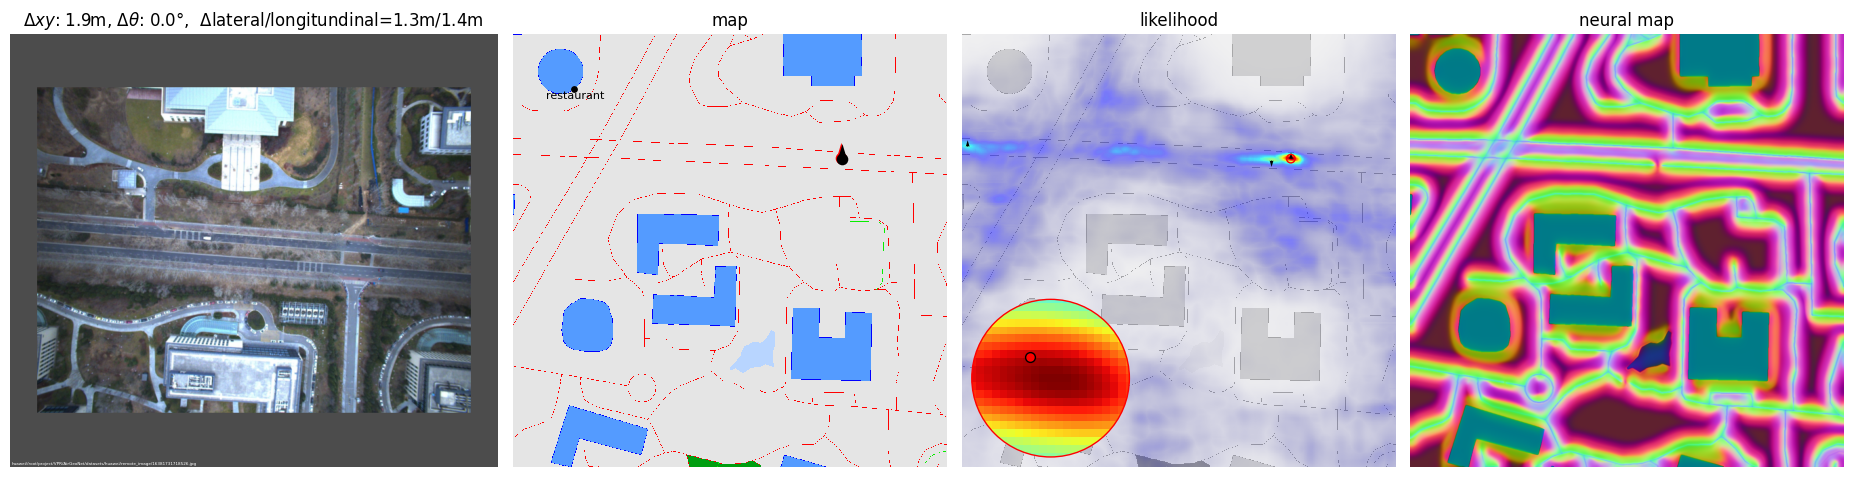

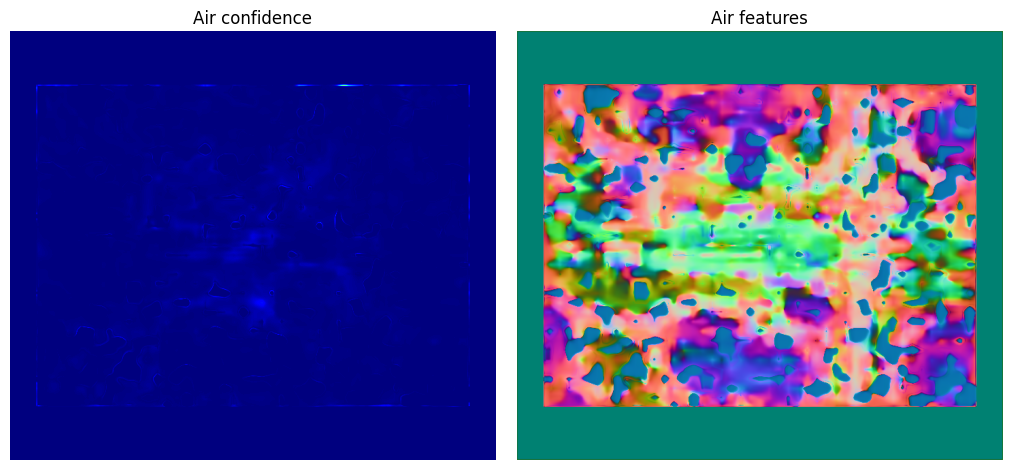

In [ ]:
out_dir = None
if out_dir is not None:
    !mkdir -p $out_dir/full
    
seed_everything(25) # best = 25
loader = dataset.dataloader("test", shuffle=sampler is None, sampler=sampler)
metrics = MetricCollection(model.model.metrics()).to(model.device)
metrics["directional_error"] = LateralLongitudinalError(model.cfg.data.pixel_per_meter)

for i, batch in zip(range(1), loader):
    lp_uvt = lp_uv = loss = results = pred = data = batch_ = None
    
    batch_ = model.transfer_batch_to_device(batch, model.device, i)
    pred = model(batch_)
    loss = model.model.loss(pred, batch_)
    results = metrics(pred, batch_)
    results.pop("xy_expectation_error")
    for k in list(results):
        if "recall" in k:
            results.pop(k)
    print(f'{i} {loss["total"].item():.2f}', {k: np.round(v.cpu().numpy(), 2) for k, v in results.items()})
#     if results["xy_max_error"] < 5:
#         continue

    pred = unbatch_to_device(pred)
    data = unbatch_to_device(batch)

    plot_example_single(i, model, pred, data, results, plot_air=True, out_dir=out_dir, show_dir_error=True)
